<a href="https://colab.research.google.com/github/Michell203/DingLab/blob/main/DLabCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install scanpy

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy

# https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html - Scanpy preprocess
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_h5ad.html - Scanpy h5ad
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_10x_h5.html - Scanpy 10x h5
# https://scanpy.readthedocs.io/en/stable/index.html - Scanpy webpage

# https://www.partek.com/webinar/understanding-data-formats-and-preprocessing/

# Preprocess
Get a sense of the data (GSM4504959_E12.5_filtered_gene_bc_matrices.h5)

Cell count: 9792,
Gene count: 27998

In [ ]:
t1 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504959_E12.5_filtered_gene_bc_matrices.h5")
t1.var_names_make_unique()
print(t1.X)

In [37]:
# print(t1.X)
array = t1.X.toarray()
number = 0
for i in range(9791):
  number += array[i,27997]
mean_of_gene1 = number/9791
print(mean_of_gene1)

0.0017481050017953662


In [43]:
t1.X

<9792x27998 sparse matrix of type '<class 'numpy.float32'>'
	with 25041018 stored elements in Compressed Sparse Row format>

In [35]:
sc.pp.normalize_total(t1, target_sum=1e4)

In [38]:
pseudobulk_h5_file_1 = t1.X.mean(axis=0)
print(pseudobulk_h5_file_1)

[[0.00113179 0.         0.         ... 0.10274449 0.000142   0.00174793]]


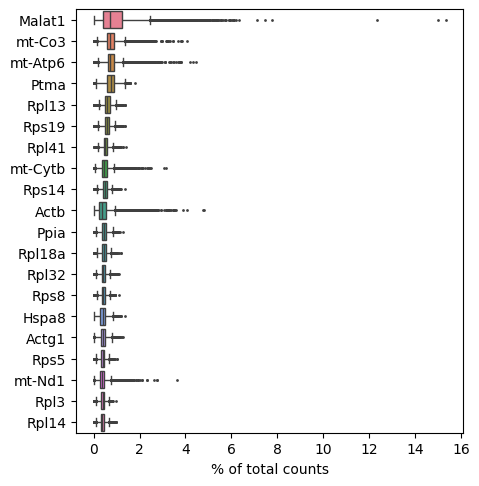

None


In [4]:
print(sc.pl.highest_expr_genes(t1, n_top=20, ))

In [5]:
sc.pp.normalize_total(t1, target_sum=1e4)
# sc.pp.log1p(t1)

In [6]:
pseudobulk_t1 = t1.X.mean(axis=0)
print(pseudobulk_t1)

[[0.00113179 0.         0.         ... 0.10274449 0.000142   0.00174793]]


In [ ]:
# Generate new information about counts
t1.var_names_make_unique()
sc.pp.calculate_qc_metrics(t1, log1p=False, inplace=True)

frame1_obs = pd.DataFrame(t1.obs)
frame1_obs.drop(['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'], axis=1)

frame1_vars = pd.DataFrame(t1.var)

In [ ]:
t1.layers["t1.X"] = t1.X
t1.to_df(layer="t1.X")

# Create Pseudobulk

In [ ]:
t0 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504959_E12.5_filtered_gene_bc_matrices.h5")
t1 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504960_E15.5_filtered_gene_bc_matrices.h5")
t2 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504961_E17.5_filtered_gene_bc_matrices.h5")
t3 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504962_P3_filtered_gene_bc_matrices.h5")
t4 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504963_P7_filtered_gene_bc_matrices.h5")
t5 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504964_P15_filtered_gene_bc_matrices.h5")
t6 = sc.read_10x_h5("/content/drive/MyDrive/Ding Lab/Data/GSM4504965_P42_filtered_gene_bc_matrices.h5")

h5_files = [t0, t1, t2, t3, t4, t5, t6]
pseudo_bulks = []

In [47]:
t0.var_names

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1', 'Sox17', 'Gm37323', 'Mrpl15',
       'Lypla1', 'Gm37988',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'PISD', 'DHRSX', 'Vmn2r122', 'CAAA01147332.1'],
      dtype='object', length=27998)

In [49]:
def pseudo_bulk(h5_file): # Creates pseudobulk of h5 file
  sc.pp.normalize_total(h5_file, target_sum=1e4)
  pseudobulk_h5_file = h5_file.X.mean(axis=0)

  values = []
  for i in range(pseudobulk_h5_file.shape[1]):
    values.append(pseudobulk_h5_file[0,i])

  return np.array(values)

In [50]:
def create_pseudo_bulk(h5_files):
  pseudo_bulks = []
  for h5_file in h5_files:
    pseudo_h5 = pseudo_bulk(h5_file)
    pseudo_bulks.append(pseudo_h5)

  return np.array(pseudo_bulks)

In [ ]:
obs_names = {}
for i in range(7):
  obs_names[i] = "TimeStamp" + str(i)
obs_frame = pd.DataFrame(list(obs_names.items()), columns=['Index', 'TimeStamp'])
print(obs_frame)

In [ ]:
bulks = create_pseudo_bulk(h5_files)
bulks_adata = ad.AnnData(bulks, obs=obs_frame, var=t0.var)

In [ ]:
print(bulks_adata.X)
print(bulks_adata.obs)
print(bulks_adata.var)